In [4]:


import glob
import os
import random
from datetime import datetime
from pathlib import Path

import laspy
import numpy as np
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader


def read_las(pointcloudfile, get_attributes=True, useevery=1):
    """
    :param pointcloudfile: specification of input file (format: las or laz)
    :param get_attributes: if True, will return all attributes in file, otherwise will only return XYZ (default is False)
    :param useevery: value specifies every n-th point to use from input, i.e. simple subsampling (default is 1, i.e. returning every point)
    :return: 3D array of points (x,y,z) of length number of points in input file (or subsampled by 'useevery')
    """

    # Read file
    inFile = laspy.read(pointcloudfile)

    # Get coordinates (XYZ)
    coords = np.vstack((inFile.x, inFile.y, inFile.z)).transpose()
    coords = coords[::useevery, :]

    # Return coordinates only
    if get_attributes == False:
        return coords

    # Return coordinates and attributes
    else:
        las_fields = [info.name for info in inFile.points.point_format.dimensions]
        attributes = {}
        # for las_field in las_fields[3:]:  # skip the X,Y,Z fields
        for las_field in las_fields:  # get all fields
            attributes[las_field] = inFile.points[las_field][::useevery]
        return (coords, attributes)


def rotate_points(coords):
    rotation = np.random.uniform(-180, 180)
    # Convert rotation values to radians
    rotation = np.radians(rotation)

    # Rotate point cloud
    rot_mat = np.array(
        [
            [np.cos(rotation), -np.sin(rotation), 0],
            [np.sin(rotation), np.cos(rotation), 0],
            [0, 0, 1],
        ]
    )

    aug_coords = coords
    aug_coords[:, :3] = np.matmul(aug_coords[:, :3], rot_mat)
    return aug_coords


def point_removal(coords, x=None):
    # Get list of ids
    idx = list(range(np.shape(coords)[0]))
    random.shuffle(idx)  # shuffle ids
    idx = np.random.choice(
        idx, random.randint(round(len(idx) * 0.9), len(idx)), replace=False
    )  # pick points randomly removing up to 10% of points

    # Remove random values
    aug_coords = coords[idx, :]  # remove coords
    if x is None:  # remove x
        aug_x = aug_coords
    else:
        aug_x = x[idx, :]

    return aug_coords, aug_x


def random_noise(coords, dim, x=None):
    # Random standard deviation value
    random_noise_sd = np.random.uniform(0.01, 0.025)

    # Add/Subtract noise
    if np.random.uniform(0, 1) >= 0.5:  # 50% chance to add
        aug_coords = coords + np.random.normal(
            0, random_noise_sd, size=(np.shape(coords)[0], 3)
        )
        if x is None:
            aug_x = aug_coords
        else:
            aug_x = x + np.random.normal(0, random_noise_sd, size=(np.shape(x)))
    else:  # 50% chance to subtract
        aug_coords = coords - np.random.normal(
            0, random_noise_sd, size=(np.shape(coords)[0], 3)
        )
        if x is None:
            aug_x = aug_coords
        else:
            aug_x = x - np.random.normal(0, random_noise_sd, size=(np.shape(x)))

    # Randomly choose up to 10% of augmented noise points
    use_idx = np.random.choice(
        aug_coords.shape[0], random.randint(0, round(len(aug_coords) * 0.1)), replace=False
    )
    aug_coords = aug_coords[use_idx, :]  # get random points
    aug_coords = np.append(coords, aug_coords, axis=0)  # add points
    aug_x = aug_x[use_idx, :]  # get random point values
    aug_x = np.append(x, aug_x)  # add random point values

    if dim == 1:
        aug_x = aug_x[:, np.newaxis]

    return aug_coords, aug_x

def write_las(outpoints,outfilepath,attribute_dict={}):

	'''

	:param outpoints: 3D array of points to be written to output file
	:param outfilepath: specification of output file (format: las or laz)
	:param attribute_dict: dictionary of attributes (key: name of attribute; value: 1D array of attribute values in order of points in 'outpoints'); if not specified, dictionary is empty and nothing is added
	:return: None
	'''

	import laspy

	hdr = laspy.LasHeader(version="1.4", point_format=6)
	hdr.x_scale = 0.00025
	hdr.y_scale = 0.00025
	hdr.z_scale = 0.00025
	mean_extent = np.mean(outpoints, axis=0)
	hdr.x_offset = int(mean_extent[0])
	hdr.y_offset = int(mean_extent[1])
	hdr.z_offset = int(mean_extent[2])

	las = laspy.LasData(hdr)

	las.x = outpoints[:, 0]
	las.y = outpoints[:, 1]
	las.z = outpoints[:, 2]
	for key,vals in attribute_dict.items():
		try:
			las[key] = vals
		except:
			las.add_extra_dim(laspy.ExtraBytesParams(
				name=key,
				type=type(vals[0])
				))
			las[key] = vals

	las.write(outfilepath)

	return

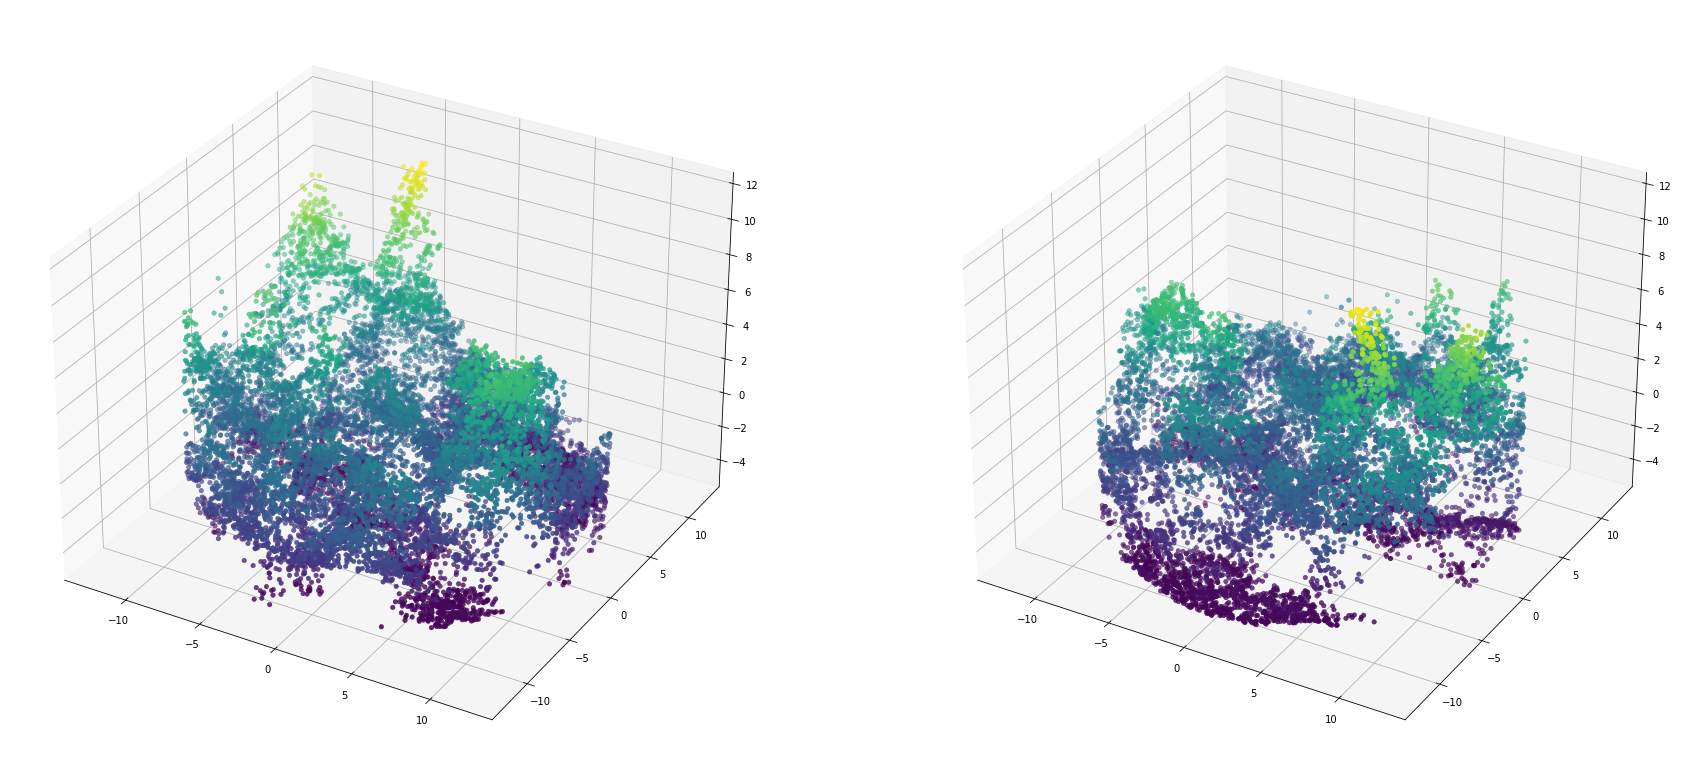

In [5]:
#Get plotting modules
import matplotlib.pyplot as plt

#Specify file
filename = r"D:\Sync\Romeo_Data\las_for_vis\13.las"

#Specify variables to include
use_columns = ['intensity']

#Specify point density
max_points = 3_000

#Load coords and attributes
coords, _ = read_las(filename, get_attributes=True)

# Resample number of points to max_points
if coords.shape[0] >= max_points:
    use_idx = np.random.choice(coords.shape[0], max_points, replace=False)
else:
    use_idx = np.random.choice(coords.shape[0], max_points, replace=True)

# centralize coordinates
coords = coords - np.mean(coords, axis=0)

# Apply augmentation
coords_aug, _ = point_removal(coords, None)
coords_aug, _ = random_noise(coords_aug, None)
coords_aug = rotate_points(coords_aug)

#Set axis variables for plotting
x = coords[:, 0]
y = coords[:, 1]
z = coords[:, 2]

x_aug = coords_aug[:, 0]
y_aug = coords_aug[:, 1]
z_aug = coords_aug[:, 2]

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=[30, 30])

# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5)

# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(x_aug, y_aug, z_aug, c=z_aug, cmap='viridis', linewidth=0.5)

plt.show()

#Export the example las files
write_las(outpoints=coords,outfilepath=fr"D:\Sync\Misc\Example_Point_Cloud_Augmentation\original_las_{max_points}_points.las")
write_las(outpoints=coords_aug,outfilepath=fr"D:\Sync\Misc\Example_Point_Cloud_Augmentation\augmented_las_{max_points}_points.las")




#write_las(outpoints=coords,outfilepath=r"D:\Sync\Misc\Example_Point_Cloud_Augmentation")

In [28]:
#Testing filtering ground points

def read_las(pointcloudfile,get_attributes=False,useevery=1,filter_ground=True,filter_height=1.3):
    '''
    :param pointcloudfile: specification of input file (format: las or laz)
    :param get_attributes: if True, will return all attributes in file, otherwise will only return XYZ (default is False)
    :param useevery: value specifies every n-th point to use from input, i.e. simple subsampling (default is 1, i.e. returning every point)
    :return: 3D array of points (x,y,z) of length number of points in input file (or subsampled by 'useevery')
    '''

    # Read the file
    inFile = laspy.read(pointcloudfile)
    # get the coordinates (XYZ)
    coords = np.vstack((inFile.x, inFile.y, inFile.z)).transpose()

    #Remove points below specified threshold
    if filter_ground == True:
        filter_arr = coords[:, 2] > filter_height
        coords = coords[filter_arr]

    #Retrieve attributes
    if get_attributes == False:
        return (coords)
    else:
        las_fields= [info.name for info in inFile.points.point_format.dimensions]
        attributes = {}
        for las_field in las_fields[3:]: # skip the X,Y,Z fields
            attributes[las_field] = inFile.points[las_field][::useevery]
        return (coords, attributes)

#Get plotting modules
import matplotlib.pyplot as plt

#Specify file
filename = r"D:\Sync\Romeo_Data\las_for_vis\13.las"

#Specify point density
max_points = 10_000

#Load coords without filtering
coords, _ = read_las(filename, get_attributes=True, useevery=1,filter_ground=False,filter_height=1.3)

#Load coords with filtering at 1.3m
filtered_coords, _ = read_las(filename, get_attributes=True, useevery=1,filter_ground=True,filter_height=1.3)

#Set axis variables for plotting
x = coords[:, 0]
y = coords[:, 1]
z = coords[:, 2]

x_filt = filtered_coords[:, 0]
y_filt = filtered_coords[:, 1]
z_filt = filtered_coords[:, 2]

print(min(filtered_coords[:, 2]))
print(min(coords[:, 2]))



1.31
0.0


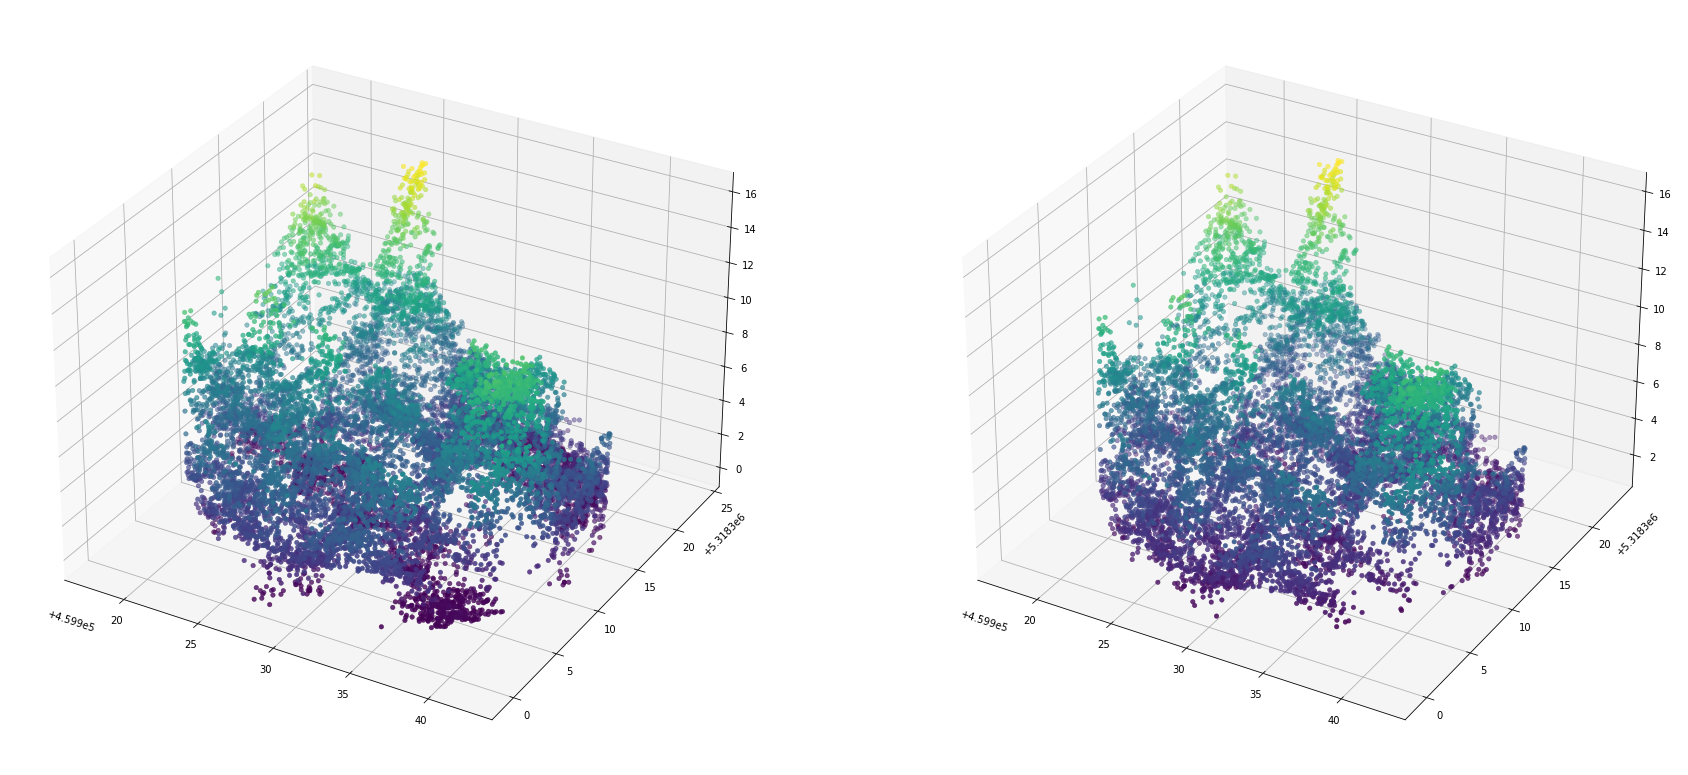

In [27]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=[30, 30])

# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5)

# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(x_filt, y_filt, z_filt, c=z_filt, cmap='viridis', linewidth=0.5)

plt.show()